# Analysis

Select modalities, events, parameters 

In [109]:
# List with optional commented-out modalities
modalities = [
    'NoseVector.x',        
    #'NoseVector.y',          
    #EyeDirWorldCombined.x', 
    #'EyeDirWorldCombined.y',  
    'EyeDirLocalCombined.x',        
    #'EyeDirLocalCombined.y',        
     'SteeringInput',         
]


# --- Toggle events by commenting them out ---
event_filter_list = [   
    # 'NoEvent', # UNCOMMENT THIS TO INCLUDE ALL EVENTS
    'StagEventNew',        
    'FallingRocksEventNew',
    'FogEventNew',         
    #'I_variant',           
    #'III_variant',
    #'MarketPlaceEvent',
    # 'CyclistEvent',       
    # 'Panne',                  
    # 'GhostDriver',
    # 'Baustelle',          
    #'MotorcyclistEvent'    ,
]

#condition_filter = 'BaseCondition'
#condition_filter = '!BaseCondition'
#condition_filter = 'HUDOnly'
#condition_filter = 'AudioOnly'
#condition_filter = 'FullLoopAR'
condition_filter = 'All Conditions'



points_per_window = 500  # 10 seconds @ 50Hz
global_sigma = 1    # smoothing strength



In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter1d


c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52104 instead
  warnings.warn(
c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (3.28s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Define and load dataframe

In [111]:
# Define dtypes to load all uid files
dtypes = {'uid': 'str','dataset': 'str','city_section': 'str','ExperimentalCondition': 'str','EventName': 'object','HitObjectName': 'object','ObjectName_4': 'object','ObjectName_5': 'object', 'EventDuration': 'float64', 'TimeStamp': 'float64'}
# Define the path to the CSV file
dir = os.getcwd()
data_path = dir + '/Data/'

# Load all data
ddf = dd.read_csv(data_path + '*.csv', assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)

# Load DataFrame  
df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
event_windows_df = df.compute() 

# Convert to pandas for processing
df = df.compute()  #  convert to full pandas DataFrame

print("DataFrame shape before event filtering:", df.shape)

# --- Filter the windows if any of these events occur in the window ---
grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

print("DataFrame shape before condition filtering:", windows_event_filtered.shape)

# Filter conditions
df = windows_event_filtered
if condition_filter != 'All Conditions':
    if condition_filter == '!BaseCondition':
        windows_event_condition_filtered = df[df['ExperimentalCondition'] != 'BaseCondition']
        condition_filter = "Any warning (non-control)"
    else:
        windows_event_condition_filtered = df[df['ExperimentalCondition'] == condition_filter]
else:
    windows_event_condition_filtered = df

print("DataFrame shape after filtering:", windows_event_condition_filtered.shape)

# Check structure  
if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
    raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")




DataFrame shape before event filtering: (873000, 90)
DataFrame shape before condition filtering: (240000, 90)
DataFrame shape after filtering: (240000, 90)


Plot raw data for each modality

Loaded 480 valid windows, shape = (480, 500, 3)
Modality 0 data shape: (480, 500)
Mean data for modality 0: [0.45305177 0.45310225 0.45322295 0.45354808 0.45380776]


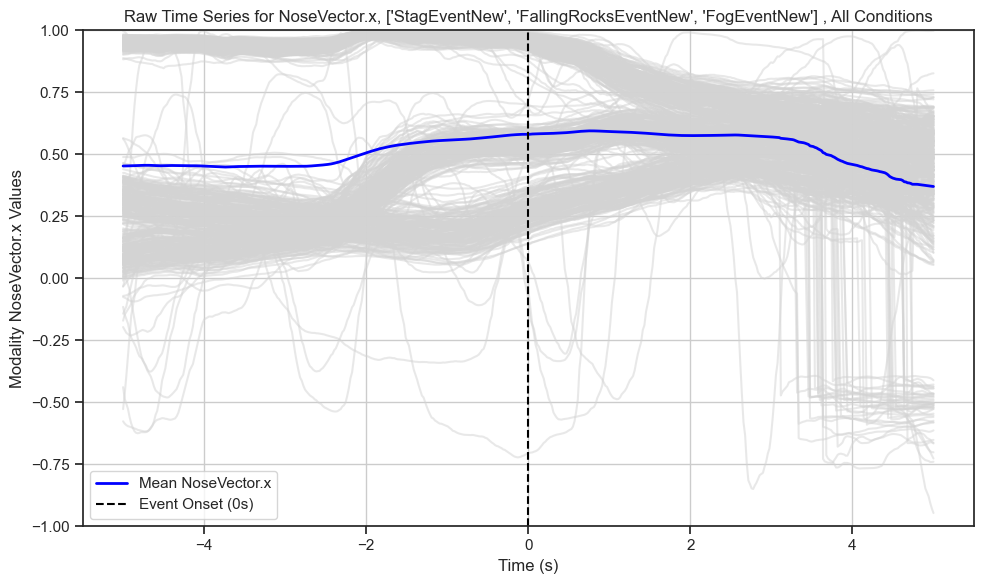

Modality 1 data shape: (480, 500)
Mean data for modality 1: [0.00755253 0.00679236 0.00559454 0.00568317 0.00816105]


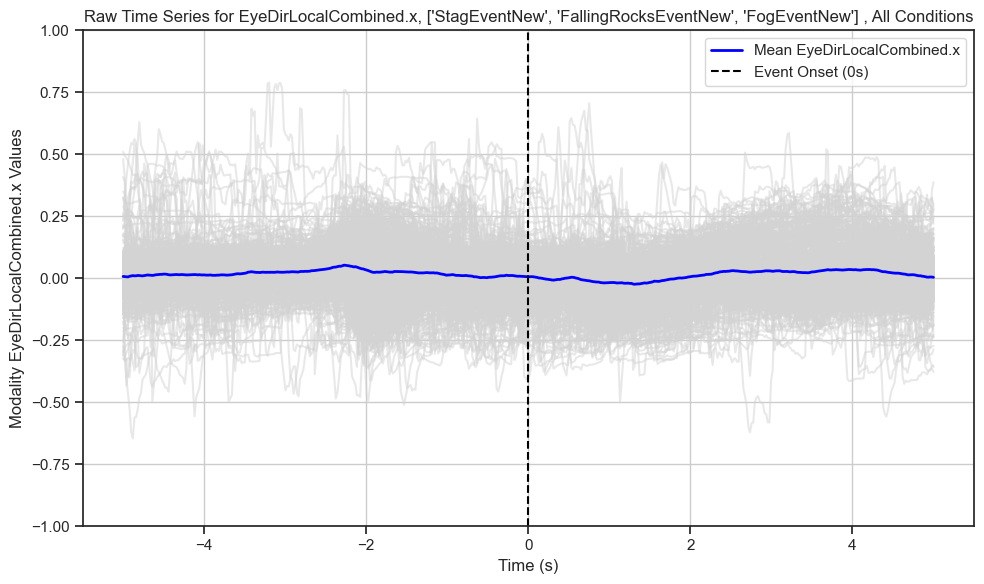

Modality 2 data shape: (480, 500)
Mean data for modality 2: [-0.01411528 -0.01400113 -0.01389646 -0.01377819 -0.01366624]


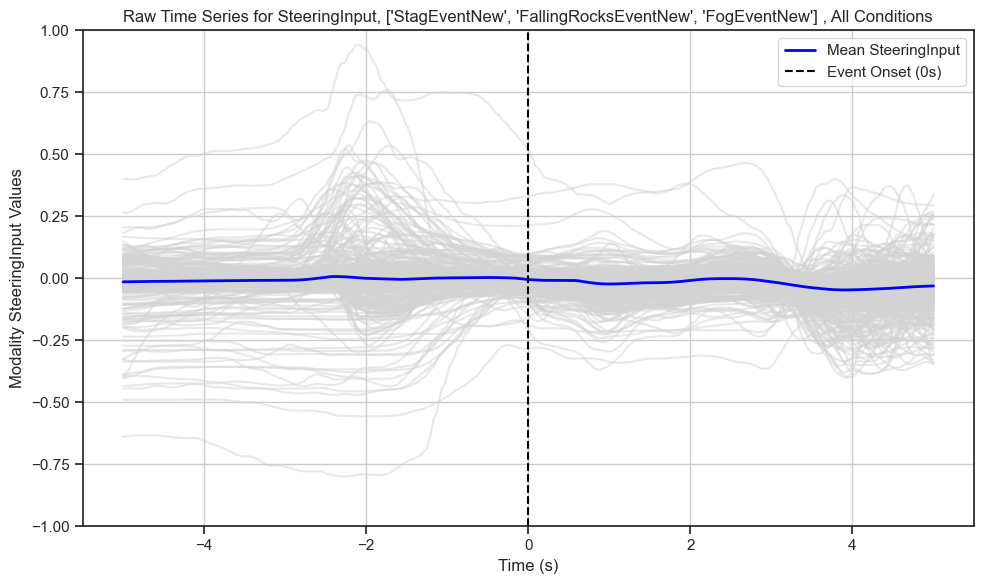

In [112]:
# Centering and standardizing data for each observation (participant's data per modality)
raw_all_participant_curves = []

for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
    if len(sub_df) != points_per_window:
        continue  # Skip incomplete windows

    if not all(col in sub_df.columns for col in modalities):
        continue

    data = sub_df[modalities].copy()
    
    raw_all_participant_curves.append(data.T)

if len(raw_all_participant_curves) == 0:
    raise ValueError("❌ No valid participant data found!")

# Stack to 3D array: (N_windows, T, M)
raw_data_array = np.stack(raw_all_participant_curves, axis=0)  # shape: (W, M, T)
raw_data_array = np.transpose(raw_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

W, T, M = raw_data_array.shape
print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
time_sec = np.linspace(-5, 5, T)# Loop through each modality (M) and plot the data for each participant
for m in range(M):
    # Extract modality-specific data
    raw_modality_data = raw_data_array[:, :, m]  # Shape: (W, T)
    
    # Debug: Check the shape of the modality data
    print(f"Modality {m} data shape: {raw_modality_data.shape}")

    # Create a new figure for each modality
    plt.figure(figsize=(10, 6))

    # Plot the raw time series for each participant
    for participant_data in raw_modality_data:
        plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

    # Compute and plot the mean time series across participants
    raw_mean_data = raw_modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
    # Debug: Check the mean data
    print(f"Mean data for modality {m}: {raw_mean_data[:5]}")  # Print first few values of mean data
    
    # Get the modality name from the modalities list
    modality_name = modalities[m]  # Assuming modalities is a list of names
    
    plt.plot(time_sec, raw_mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

    plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
    plt.xlabel("Time (s)")
    plt.ylabel(f"Modality {modality_name} Values")
    plt.title(f"Raw Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
    # Set y-axis limits
    plt.ylim(-1, 1)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Center and standardize

Loaded 480 windows; array shapes raw/scaled = (480, 500, 3) / (480, 500, 3)


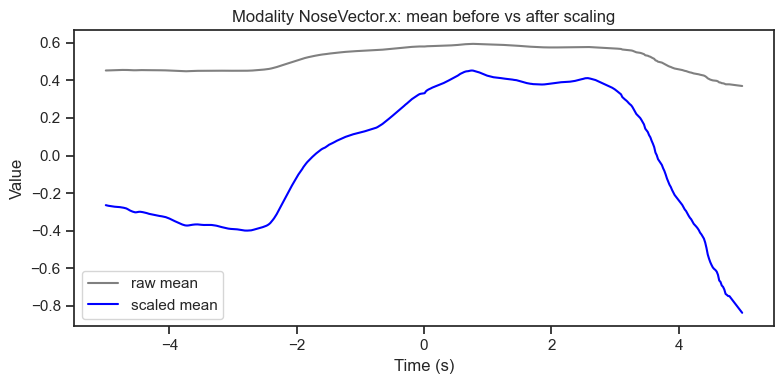

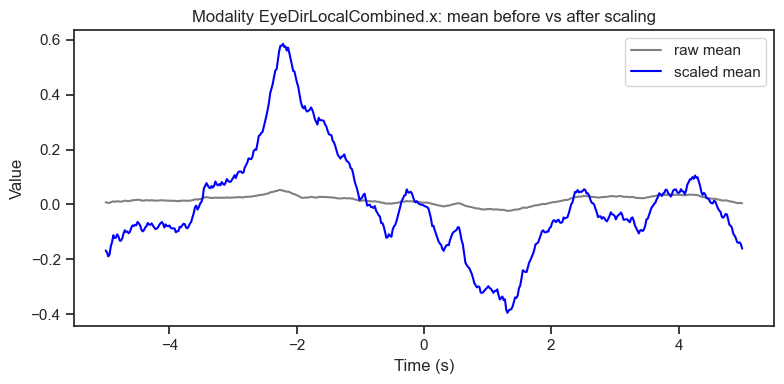

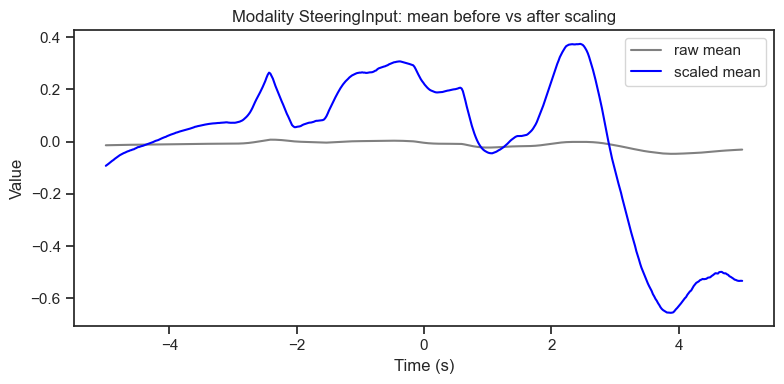

Before scaling per‐modality std: [0.29621115 0.10202603 0.08296367]
After  scaling per‐modality std: [1.00000208 1.00000208 1.00000208]


In [113]:
# Prepare lists to collect “before” (raw) and “after” (scaled) curves
raw_participant_curves    = []
scaled_participant_curves = []

# Loop over each window (participant × WindowNumber)
for (_, _), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
    if len(sub_df) != points_per_window:
        continue
    if not all(col in sub_df.columns for col in modalities):
        continue

    # 1) Extract the T×M block of data
    data = sub_df[modalities].copy()                # pandas DataFrame, shape (T, M)

    # 2) Save raw values
    raw_values = data.values.copy()                  # numpy array, shape (T, M)

    # 3) Center each curve (each column) on its own mean
    data_centered = data - data.mean(axis=0)         # subtract column‐wise mean

    # 4) Standardize each curve across time
    scaler     = StandardScaler()
    scaled     = scaler.fit_transform(data_centered) # numpy array, shape (T, M)

    # 5) Store transposed for stacking: now (M, T)
    raw_participant_curves.append   ( raw_values.T )
    scaled_participant_curves.append( scaled.T     )

# Sanity check
if not raw_participant_curves:
    raise ValueError("❌ No valid participant data found!")

# Stack into arrays of shape (W, M, T) then transpose to (W, T, M)
Pca_rawdata_array = np.stack(raw_participant_curves,    axis=0)  # (W, M, T)
Pca_rawdata_array = np.transpose(Pca_rawdata_array, (0, 2, 1))  # (W, T, M)

Pca_data_array    = np.stack(scaled_participant_curves, axis=0)  # (W, M, T)
Pca_data_array    = np.transpose(Pca_data_array,    (0, 2, 1))  # (W, T, M)

W, T, M = Pca_data_array.shape
print(f"Loaded {W} windows; array shapes raw/scaled = {Pca_rawdata_array.shape} / {Pca_data_array.shape}")

time_sec = np.linspace(-5, 5, T)

# Plot mean before vs after scaling for each modality
for m in range(M):
    plt.figure(figsize=(8, 4))
    mean_raw    = Pca_rawdata_array[:, :, m].mean(axis=0)
    mean_scaled = Pca_data_array[:, :, m].mean(axis=0)

    plt.plot(time_sec, mean_raw,    label='raw mean',    color='gray')
    plt.plot(time_sec, mean_scaled, label='scaled mean', color='blue')

    plt.title(f"Modality {modalities[m]}: mean before vs after scaling")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Compare per‐modality std‐dev before/after
raw_flat    = Pca_rawdata_array.reshape(-1, M)
scaled_flat = Pca_data_array.reshape(-1, M)

print("Before scaling per‐modality std:", raw_flat.std(axis=0, ddof=1))
print("After  scaling per‐modality std:", scaled_flat.std(axis=0, ddof=1))


Plot centered and standardized variables

Modality 0 data shape: (480, 500)
Mean data for modality 0: [-0.26452971 -0.26629257 -0.26778922 -0.26884302 -0.27005343]


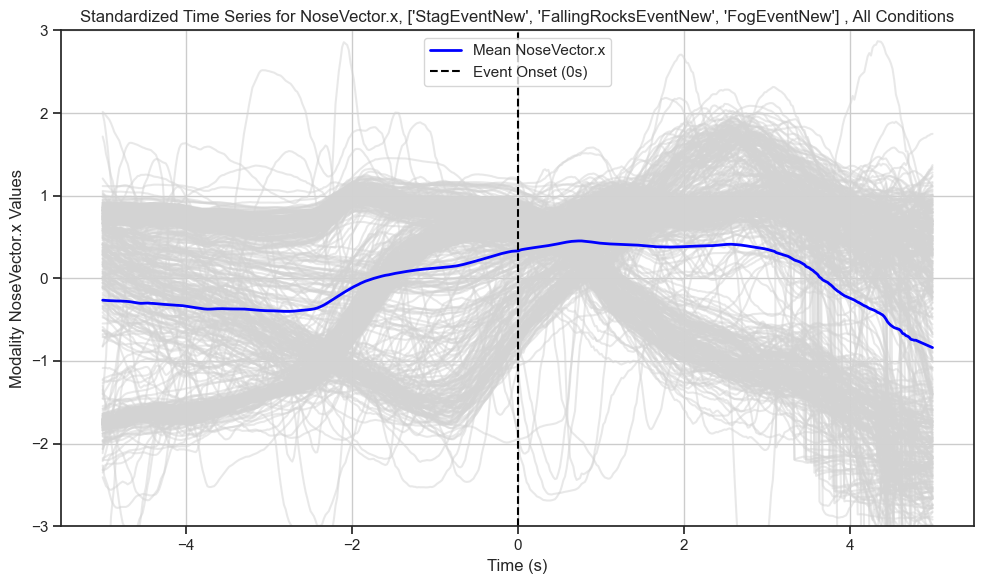

Modality 1 data shape: (480, 500)
Mean data for modality 1: [-0.16803024 -0.17484413 -0.18947744 -0.18342789 -0.15279749]


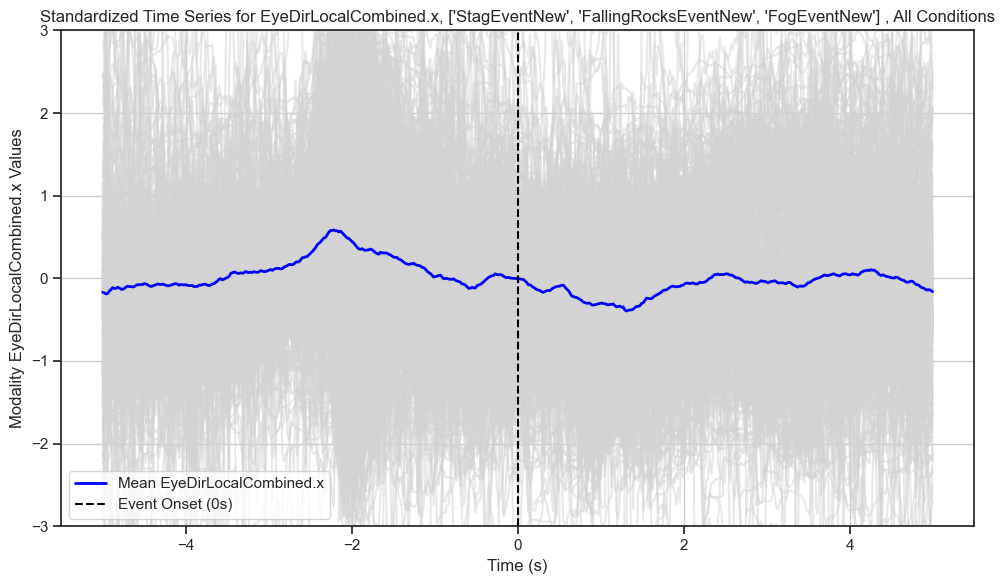

Modality 2 data shape: (480, 500)
Mean data for modality 2: [-0.09269377 -0.08917533 -0.08545376 -0.08149468 -0.07773032]


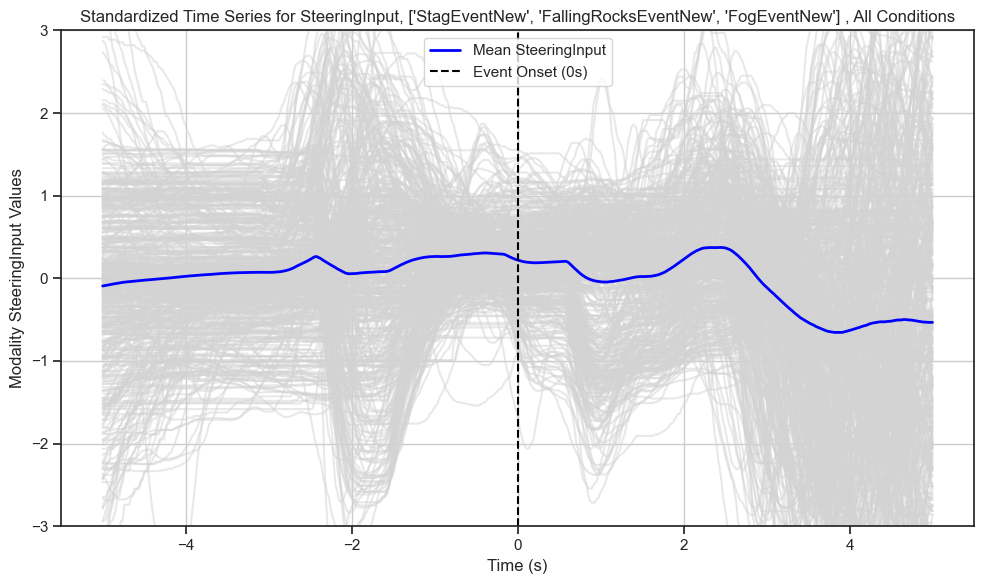

In [114]:
# Loop through each modality (M) and plot the data for each participant
for m in range(M):
    # Extract modality-specific data
    modality_data = Pca_data_array[:, :, m]  # Shape: (W, T)
    
    # Debug: Check the shape of the modality data
    print(f"Modality {m} data shape: {modality_data.shape}")

    # Create a new figure for each modality
    plt.figure(figsize=(10, 6))

    # Plot the raw time series for each participant
    for participant_data in modality_data:
        plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

    # Compute and plot the mean time series across participants
    mean_data = modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
    # Debug: Check the mean data
    print(f"Mean data for modality {m}: {mean_data[:5]}")  # Print first few values of mean data
    
    # Get the modality name from the modalities list
    modality_name = modalities[m]  # Assuming modalities is a list of names
    
    plt.plot(time_sec, mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

    plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
    plt.xlabel("Time (s)")
    plt.ylabel(f"Modality {modality_name} Values")
    plt.title(f"Standardized Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
    # Set y-axis limits
    plt.ylim(-3, 3)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Time-wise PCA ED Curve

In [115]:
# # --- Compute cov matrix ---
# cov_matrix = np.zeros((T, M, M))

# # Compute covariance matrix for each time step
# for t in range(T):
#     snapshot = data_array[:, t, :]  # shape: (W, M)
#     centered = snapshot - snapshot.mean(axis=0)
#     cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)
# # --- Compute ED Over Time (Quadratic Entropy) ---
# ed_curve = []

# for t in range(T):
#     eigvals = eigh(cov_matrix[t], eigvals_only=True)
#     eigvals = np.clip(eigvals, 1e-12, None)
#     p = eigvals / np.sum(eigvals)
#     ED = 1 / np.sum(p**2)    
#     ed_curve.append(ED)

# # --- Smooth the ED Curve ---
# smoothed_ed = gaussian_filter1d(ed_curve, sigma=global_sigma)

# # --- Plot ED Curve ---
# seconds = np.linspace(0, 10, T)

# plt.figure(figsize=(10, 6))
# plt.plot(seconds, ed_curve, color='lightgray', linewidth=1, label='Original ED', alpha=0.5)
# plt.plot(seconds, smoothed_ed, color='blue', linewidth=2, label='Smoothed ED (σ= {global_sigma})')
# plt.axvline(5, color='gray', linestyle='--', label='Event Onset (0s)')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities}, {condition_filter}, {event_filter_list}")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# # --- Compute PCA based Global Scalar ED ---
# # Extract eigenvalues from covariance matrix at time 0 (or any time slice)
# Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
# Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
# p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
# ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# # --- Report ---
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


# Optional: To overlay each variable on top of the time-wise ED 
 
 
 Run the whole script with this block commented out, for correct filtering of the next steps

In [116]:
# local_sigma = 5
# global_sigma = local_sigma     # smoothing strength

# # Set whether to plot all events together or separately
# plot_separately = True  # Change this to True if you want to plot each event separately

# # --- Define condition filters ---
# condition_filters = [
#     'BaseCondition', 
#     #'!BaseCondition',
#     'HUDOnly', 
#     'AudioOnly', 
#     'FullLoopAR', 
#     #'All Conditions'
# ]


# # List of colors for each condition
# colors = {
#     'BaseCondition': 'pink',
#     '!BaseCondition': 'black',
#     'HUDOnly': 'red',
#     'AudioOnly': 'blue',
#     'FullLoopAR': 'green',
#     'All Conditions': 'purple'  
# }

# # --- OPTIONAL: Data Loading, Filtering, and Preparation ---


# # Load the DataFrame  
# df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
# event_windows_df = df.compute() 

# # Convert to pandas for processing
# df = df.compute()  # Convert to full pandas DataFrame

# print("DataFrame shape before event filtering:", df.shape)

# # --- Filter the windows if any of these events occur in the window ---
# grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
# windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

# print("DataFrame shape before condition filtering:", windows_event_filtered.shape)


# # --- Apply condition filters ---
# df = windows_event_filtered
# non_base_conditions = ['HUDOnly', 'AudioOnly', 'FullLoopAR']  # Define non-base conditions

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for condition_filter in condition_filters:
#     condition_label = condition_filter  # Set the label to the condition_filter for use in the plot

#     if condition_filter == 'All Conditions':
#         windows_event_condition_filtered = df
#     elif condition_filter == 'BaseCondition':
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == 'BaseCondition']
#     elif condition_filter == '!BaseCondition':
#         # Combine all non-base conditions
#         windows_event_condition_filtered = df[df['ExperimentalCondition'].isin(non_base_conditions)]
#         condition_label = "Non-Base Conditions"  # Label it as "Non-Base Conditions"
#     else:
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == condition_filter]

#     print(f"DataFrame shape for {condition_label}:", windows_event_condition_filtered.shape)

#     # --- Check structure ---
#     if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
#         raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")

#     all_participant_curves = []

#     for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
#         if len(sub_df) != points_per_window:
#             continue  # Skip incomplete windows

#         if not all(col in sub_df.columns for col in modalities):
#             continue

#         data = sub_df[modalities].copy()
#         scaler = StandardScaler()
#         data_scaled = scaler.fit_transform(data)
#         all_participant_curves.append(data_scaled.T)

#     if len(all_participant_curves) == 0:
#         print(f"❌ No valid participant data found for condition '{condition_label}'")
#         continue  # Skip to next condition

#     # Stack to 3D array: (N_windows, T, M)
#     data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
#     data_array = np.transpose(data_array, (0, 2, 1))  # Convert to shape (W, T, M)

#     W, T, M = data_array.shape
#     print(f"Loaded {W} valid windows for condition '{condition_label}', shape = ({W}, {T}, {M})")

#     # --- Compute covariance matrix ---
#     cov_matrix = np.zeros((T, M, M))

#     # Compute covariance matrix for each time step
#     for t in range(T):
#         snapshot = data_array[:, t, :]  # shape: (W, M)
#         centered = snapshot - snapshot.mean(axis=0)
#         cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)

#     # --- Compute ED Over Time (Quadratic Entropy) ---
#     ed_curve = []
#     for t in range(T):
#         eigvals = eigh(cov_matrix[t], eigvals_only=True)
#         eigvals = np.clip(eigvals, 1e-12, None)
#         p = eigvals / np.sum(eigvals)
#         ED = 1 / np.sum(p**2)    
#         ed_curve.append(ED)

#     # --- Smooth the ED Curve ---
#     smoothed_ed = gaussian_filter1d(ed_curve, sigma=global_sigma)

#     # --- Plot ED Curve for each condition, overlaid ---
#     seconds = np.linspace(0, 10, T)
#     plt.plot(seconds, smoothed_ed, label=f'{condition_label} ED', linewidth=2, color=colors.get(condition_label, 'black'))

# # --- Add plot details ---
# plt.axvline(5, color='gray', linestyle='--', label='Event Onset (0s)')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- Compute Global Scalar ED ---
# # Extract eigenvalues from covariance matrix at time 0 (or any time slice)
# Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
# Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
# p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
# ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# # --- Report ---
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


In [117]:
# local_sigma = 1     # smoothing strength

# # Set whether to plot all events together or separately
# plot_separately = True  # Change this to True if you want to plot each event separately

# # --- Define condition filters ---
# local_condition_filters = [
#     'BaseCondition', 
#     '!BaseCondition',
#     #'HUDOnly', 
#     #'AudioOnly', 
#     #'FullLoopAR', 
#     #'All Conditions'
# ]


# # List of colors for each condition
# colors = {
#     'BaseCondition': 'pink',
#     '!BaseCondition': 'black',
#     'HUDOnly': 'red',
#     'AudioOnly': 'blue',
#     'FullLoopAR': 'green',
#     'All Conditions': 'purple'  
# }

# # --- OPTIONAL: Data Loading, Filtering, and Preparation ---


# # Load the DataFrame  
# dflocal = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
# event_windows_df = dflocal.compute() 

# # # Convert to pandas for processing
# # dflocal = dflocal.compute()  # Convert to full pandas DataFrame

# print("DataFrame shape before event filtering:", df.shape)

# # --- Filter the windows if any of these events occur in the window ---
# grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
# windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

# print("DataFrame shape before condition filtering:", windows_event_filtered.shape)


# # --- Apply condition filters ---
# df = windows_event_filtered
# non_base_conditions = ['HUDOnly', 'AudioOnly', 'FullLoopAR']  # Define non-base conditions

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for local_condition_filter in local_condition_filters:
#     condition_label = local_condition_filter  # Set the label to the condition_filter for use in the plot

#     if local_condition_filter == 'All Conditions':
#         windows_event_condition_filtered = df
#     elif local_condition_filter == 'BaseCondition':
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == 'BaseCondition']
#     elif local_condition_filter == '!BaseCondition':
#         # Combine all non-base conditions
#         windows_event_condition_filtered = df[df['ExperimentalCondition'].isin(non_base_conditions)]
#         condition_label = "Non-Base Conditions"  # Label it as "Non-Base Conditions"
#     else:
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == local_condition_filter]

#     print(f"DataFrame shape for {condition_label}:", windows_event_condition_filtered.shape)

#     # --- Check structure ---
#     if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
#         raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")

#     all_participant_curves = []

#     for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
#         if len(sub_df) != points_per_window:
#             continue  # Skip incomplete windows

#         if not all(col in sub_df.columns for col in modalities):
#             continue

#         data = sub_df[modalities].copy()

#         # Center each participant's data (curve) on its own mean
#         for modality_idx in range(data.shape[1]):
#             modality_data = data.iloc[:, modality_idx].values  # Extract modality data for current participant
#             modality_data_centered = modality_data - modality_data.mean()  # Center the data
#             data.iloc[:, modality_idx] = modality_data_centered  # Replace the modality with centered data

#         # Standardize each modality's data across all participants
#         scaler = StandardScaler()
#         data_scaled = scaler.fit_transform(data)
        
#         # Plot the newly transformed (centered and standardized) data for each modality
#         time_sec = np.linspace(-5, 5, T)  # Time vector (make sure T is defined)
#         for m in range(data_scaled.shape[1]):  # Iterate over modalities
#             plt.figure(figsize=(10, 6))
#             modality_data = data_scaled[:, m]  # Get the modality data for plotting
#             # Plot each participant's transformed data (before PCA)
#             for participant_data in modality_data:
#                 plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data
#             # Plot the mean transformed data across participants
#             mean_data = modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
#             plt.plot(time_sec, mean_data, label=f"Mean {modalities[m]}", color='blue', linewidth=2)  # Mean line

#             plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#             plt.xlabel("Time (s)")
#             plt.ylabel(f"Transformed {modalities[m]} Values")
#             plt.title(f"Transformed Time Series for {modalities[m]} (Centered & Standardized)")
#             plt.legend()
#             plt.grid(True)
#             plt.tight_layout()
#             plt.show()
        
#         all_participant_curves.append(data_scaled.T)

#     if len(all_participant_curves) == 0:
#         raise ValueError("❌ No valid participant data found!")

#     # Stack to 3D array: (N_windows, T, M)
#     t_data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
#     t_data_array = np.transpose(t_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

#     W, T, M = t_data_array.shape
#     print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")



#     # --- Compute covariance matrix ---
#     cov_matrix = np.zeros((T, M, M))

#     # Compute covariance matrix for each time step
#     for t in range(T):
#         snapshot = t_data_array[:, t, :]  # shape: (W, M)
#         centered = snapshot - snapshot.mean(axis=0)
#         cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)

#     # --- Compute ED Over Time (Quadratic Entropy) ---
#     ed_curve = []
#     for t in range(T):
#         eigvals = eigh(cov_matrix[t], eigvals_only=True)
#         eigvals = np.clip(eigvals, 1e-12, None)
#         p = eigvals / np.sum(eigvals)
#         ED = 1 / np.sum(p**2)    
#         ed_curve.append(ED)

#     # --- Smooth the ED Curve ---
#     smoothed_ed = gaussian_filter1d(ed_curve, sigma=local_sigma)

#     # --- Plot ED Curve for each condition, overlaid ---
#     seconds = np.linspace(-5, 5, T)
#     plt.plot(seconds, smoothed_ed, label=f'{condition_label} ED', linewidth=2, color=colors.get(condition_label, 'black'))

# # --- Add plot details ---
# plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- Compute PCA based Global Scalar ED ---
# # Extract eigenvalues from covariance matrix at time 0 (or any time slice)
# Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
# Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
# p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
# ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# # --- Report ---
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


DataFrame shape before event filtering: (873000, 90)
DataFrame shape before condition filtering: (240000, 90)
DataFrame shape for BaseCondition: (64500, 90)
Loaded 129 valid windows for condition 'BaseCondition', shape = (129, 500, 3)
DataFrame shape for Non-Base Conditions: (175500, 90)
Loaded 351 valid windows for condition 'Non-Base Conditions', shape = (351, 500, 3)


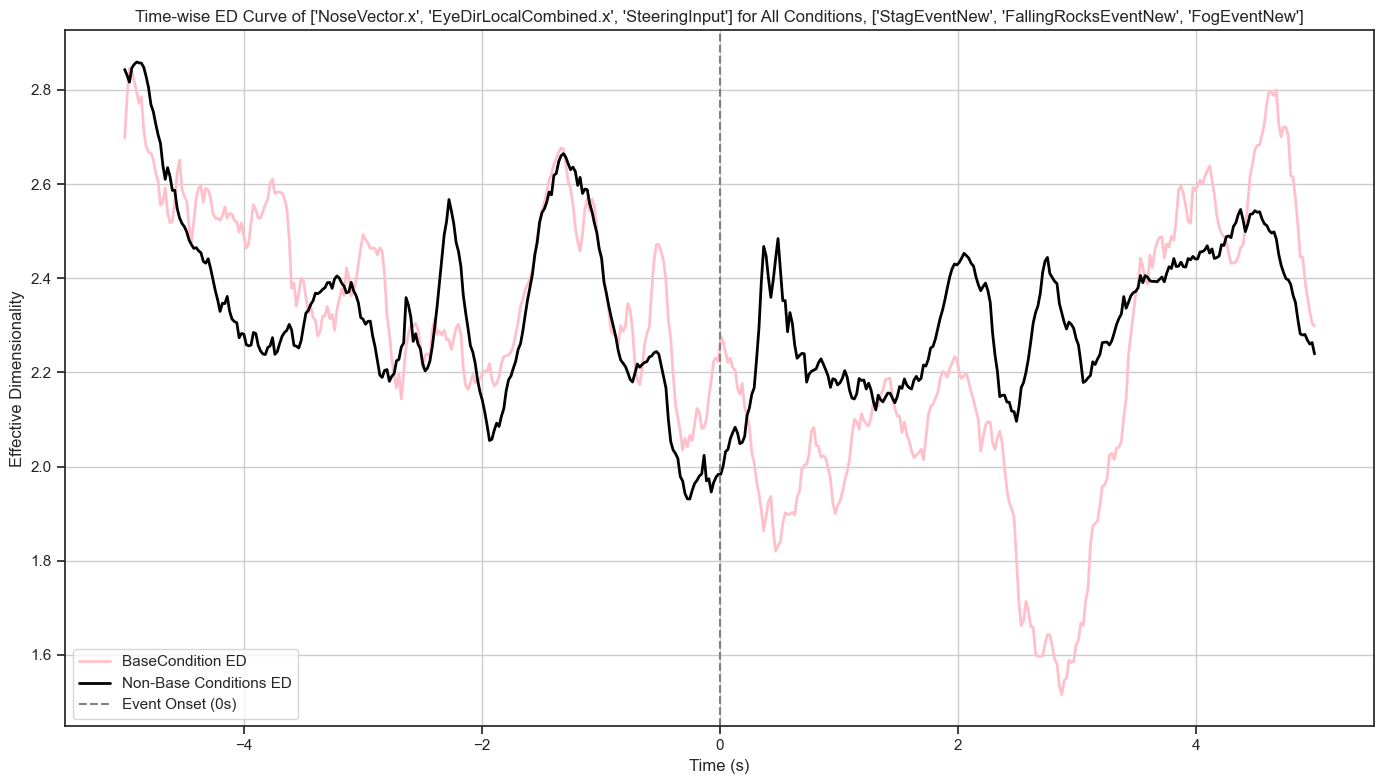

PCA based global scalar ED: 2.84 using 3 components


In [118]:
global_sigma = 0.00001      # smoothing strength

# Set whether to plot all events together or separately
plot_separately = True  # Change this to True if you want to plot each event separately

# --- Define condition filters ---
condition_filters = [
    'BaseCondition', 
    '!BaseCondition',
    #'HUDOnly', 
    #'AudioOnly', 
    #'FullLoopAR', 
    #'All Conditions'
]


# List of colors for each condition
colors = {
    'BaseCondition': 'pink',
    '!BaseCondition': 'black',
    'HUDOnly': 'red',
    'AudioOnly': 'blue',
    'FullLoopAR': 'green',
    'All Conditions': 'purple'  
}

# --- OPTIONAL: Data Loading, Filtering, and Preparation ---


# Load the DataFrame  
df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
event_windows_df = df.compute() 

# Convert to pandas for processing
df = df.compute()  # Convert to full pandas DataFrame

print("DataFrame shape before event filtering:", df.shape)

# --- Filter the windows if any of these events occur in the window ---
grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

print("DataFrame shape before condition filtering:", windows_event_filtered.shape)


# --- Apply condition filters ---
df = windows_event_filtered
non_base_conditions = ['HUDOnly', 'AudioOnly', 'FullLoopAR']  # Define non-base conditions

# Start plotting to avoid overwriting
plt.figure(figsize=(14, 8))

for condition_filter in condition_filters:
    condition_label = condition_filter  # Set the label to the condition_filter for use in the plot

    if condition_filter == 'All Conditions':
        windows_event_condition_filtered = df
    elif condition_filter == 'BaseCondition':
        windows_event_condition_filtered = df[df['ExperimentalCondition'] == 'BaseCondition']
    elif condition_filter == '!BaseCondition':
        # Combine all non-base conditions
        windows_event_condition_filtered = df[df['ExperimentalCondition'].isin(non_base_conditions)]
        condition_label = "Non-Base Conditions"  # Label it as "Non-Base Conditions"
    else:
        windows_event_condition_filtered = df[df['ExperimentalCondition'] == condition_filter]

    print(f"DataFrame shape for {condition_label}:", windows_event_condition_filtered.shape)

    # --- Check structure ---
    if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
        raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")

    all_participant_curves = []

    for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
        if len(sub_df) != points_per_window:
            continue  # Skip incomplete windows

        if not all(col in sub_df.columns for col in modalities):
            continue

        data = sub_df[modalities].copy()
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        all_participant_curves.append(data_scaled.T)

    if len(all_participant_curves) == 0:
        print(f"❌ No valid participant data found for condition '{condition_label}'")
        continue  # Skip to next condition

    # Stack to 3D array: (N_windows, T, M)
    t_data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
    t_data_array = np.transpose(t_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

    W, T, M = t_data_array.shape
    print(f"Loaded {W} valid windows for condition '{condition_label}', shape = ({W}, {T}, {M})")

    # --- Compute covariance matrix ---
    cov_matrix = np.zeros((T, M, M))

    # Compute covariance matrix for each time step
    for t in range(T):
        snapshot = t_data_array[:, t, :]  # shape: (W, M)
        centered = snapshot - snapshot.mean(axis=0)
        cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)

    # --- Compute ED Over Time (Quadratic Entropy) ---
    ed_curve = []
    for t in range(T):
        eigvals = eigh(cov_matrix[t], eigvals_only=True)
        eigvals = np.clip(eigvals, 1e-12, None)
        p = eigvals / np.sum(eigvals)
        ED = 1 / np.sum(p**2)    
        ed_curve.append(ED)

    # --- Smooth the ED Curve ---
    smoothed_ed = gaussian_filter1d(ed_curve, sigma=global_sigma)

    # --- Plot ED Curve for each condition, overlaid ---
    seconds = np.linspace(-5, 5, T)
    plt.plot(seconds, smoothed_ed, label=f'{condition_label} ED', linewidth=2, color=colors.get(condition_label, 'black'))

# --- Add plot details ---
plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.title(f"Time-wise ED Curve of {modalities} for All Conditions, {event_filter_list}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Compute PCA based Global Scalar ED ---
# Extract eigenvalues from covariance matrix at time 0 (or any time slice)
Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# --- Report ---
print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


# FPCA

In [119]:
W, T, M = Pca_data_array.shape

# --- FPCA Analysis ---
data_array_flat = Pca_data_array.reshape(W, T * M)  # (W, T*M)
fd = FDataGrid(data_array_flat, grid_points=np.linspace(0, 1, T * M))

# Perform FPCA
n_components = min(W, T * M)  # Ensure n_components doesn't exceed the number of data windows
fpca = FPCA(n_components=n_components)
fpca.fit(fd)

# FPCA Eigenvalues
FPCA_eigenvalues = fpca.explained_variance_
#FPCA_eigenvalues = np.clip(FPCA_eigenvalues, a_min=1e-12, a_max=None)  # Avoid very small eigenvalues
p = FPCA_eigenvalues / np.sum(FPCA_eigenvalues)  # Normalize the eigenvalues
ED_global = 1 / np.sum(p**2)  # Compute global scalar ED

# FPCA Eigenfunctions (use all components)
FPCA_eigenfunctions = fpca.components_.data_matrix[..., 0]
print(FPCA_eigenfunctions.shape)
n_components = FPCA_eigenfunctions.shape[0]  # Number of components after FPCA

# Report results
print(f"FPCA based global scalar ED: {ED_global:.2f} using {n_components} components")
print(f"windows: {W}\ntimepoints: {T}\nmodalities: {M}")

(480, 1500)
FPCA based global scalar ED: 7.04 using 480 components
windows: 480
timepoints: 500
modalities: 3


Calculate cumulative amount of variance explained

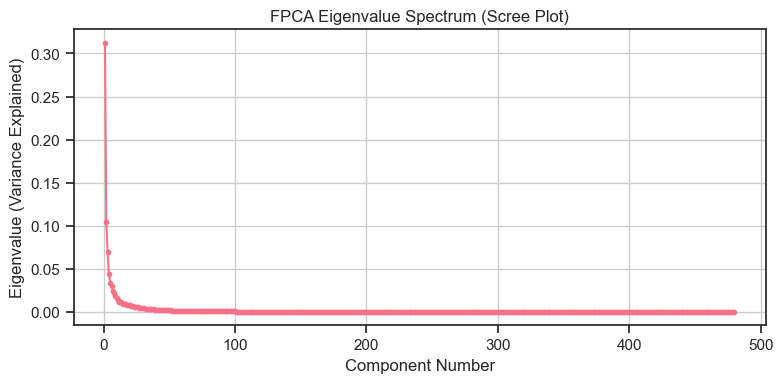

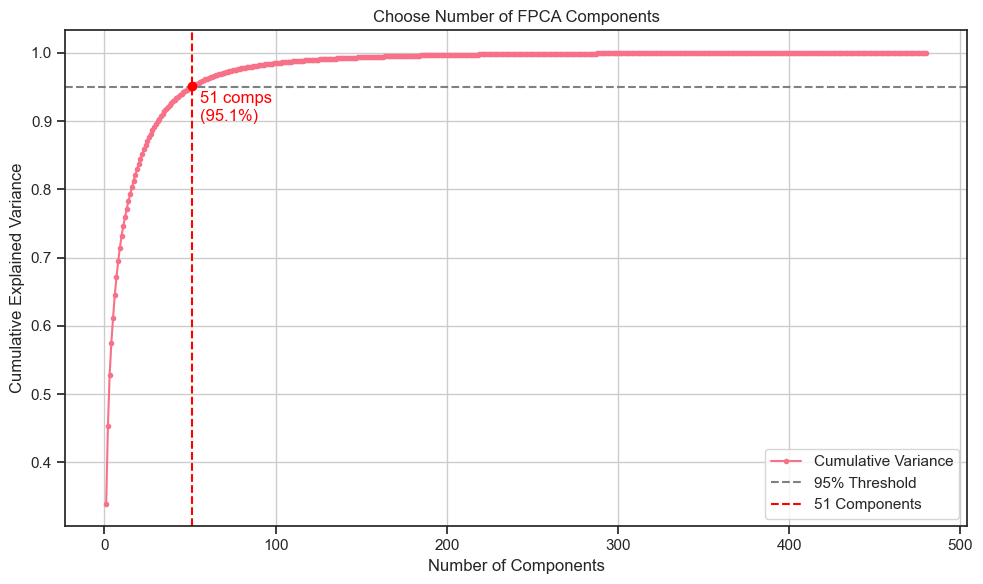

 Number of components to reach 95% explained variance: 51


In [120]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(FPCA_eigenvalues)+1), FPCA_eigenvalues, marker='o',markersize=3)
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue (Variance Explained)")
plt.title("FPCA Eigenvalue Spectrum (Scree Plot)")
plt.grid(True)
plt.tight_layout()
plt.show()


################################################v

#   After fitting FPCA with a large number of components  
cumulative_variance = np.cumsum(FPCA_eigenvalues) / np.sum(FPCA_eigenvalues)

#   Find number of components to reach 95%  
threshold = 0.95
num_components_95 = np.argmax(cumulative_variance >= threshold) + 1  # +1 for 1-based count

#   Plot  
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(FPCA_eigenvalues) + 1), cumulative_variance, marker='o',markersize=3, label="Cumulative Variance")
plt.axhline(threshold, color='gray', linestyle='--', label='95% Threshold')
plt.axvline(num_components_95, color='red', linestyle='--', label=f'{num_components_95} Components')
plt.scatter(num_components_95, cumulative_variance[num_components_95 - 1], color='red', zorder=5)

# Annotations
plt.text(num_components_95 + 5, cumulative_variance[num_components_95 - 1] - 0.05,
         f"{num_components_95} comps\n({cumulative_variance[num_components_95 - 1]*100:.1f}%)",
         color='red')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Choose Number of FPCA Components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f" Number of components to reach 95% explained variance: {num_components_95}")

Optional, if a new FPCA is to be run with a reduced #components

In [121]:
# # --- FPCA Analysis ---

# data_array_flat = data_array.reshape(W, T * M)  # (W, T*M)
# fd = FDataGrid(data_array_flat, grid_points=np.linspace(0, 1, T * M))

# # Perform FPCA
# n_components = num_components_95  # Ensure n_components doesn't exceed the number of data windows
# fpca = FPCA(n_components=n_components)
# fpca.fit(fd)

# # FPCA Eigenvalues
# FPCA_eigenvalues = fpca.explained_variance_
# FPCA_eigenvalues = np.clip(FPCA_eigenvalues, a_min=1e-12, a_max=None)  # Avoid very small eigenvalues
# p = FPCA_eigenvalues / np.sum(FPCA_eigenvalues)  # Normalize the eigenvalues
# ED_global = 1 / np.sum(p**2)  # Compute global scalar ED

# # FPCA Eigenfunctions (use all components)
# FPCA_eigenfunctions = fpca.components_.data_matrix[..., 0]
# n_components = FPCA_eigenfunctions.shape[0]  # Number of components after FPCA

# # Report results
# print(f"FPCA based global scalar ED: {ED_global:.2f} using {n_components} components")
# print(f"windows: {W}\ntimepoints: {T}\nmodalities: {M}")

(500, 3)


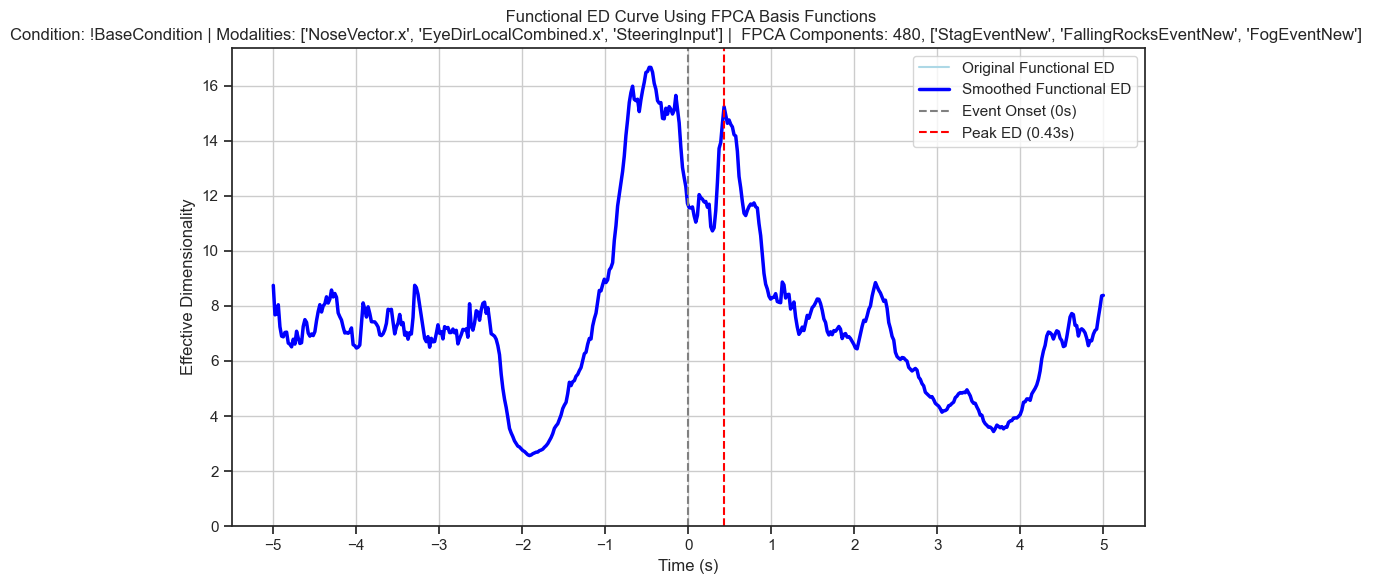

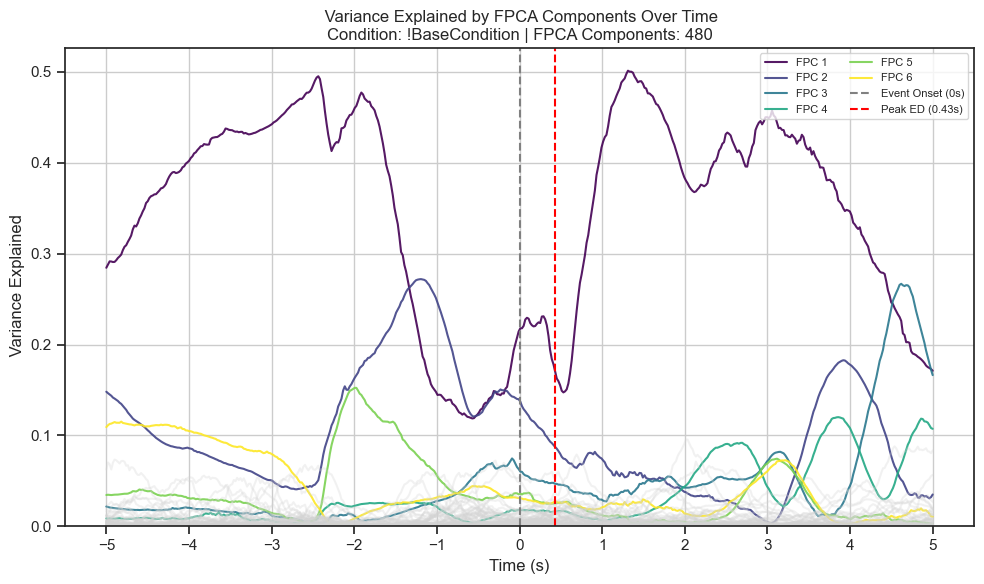


Top 6 components (% variance explained):
FPC 1: 33.96%
FPC 2: 11.31%
FPC 3: 7.50%
FPC 4: 4.71%
FPC 5: 3.68%
FPC 6: 3.31%


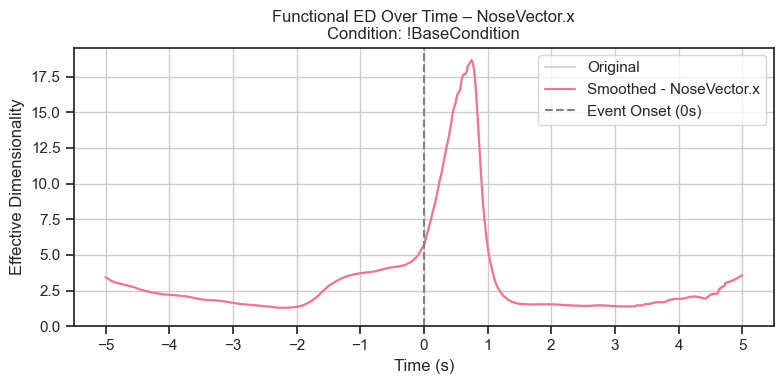

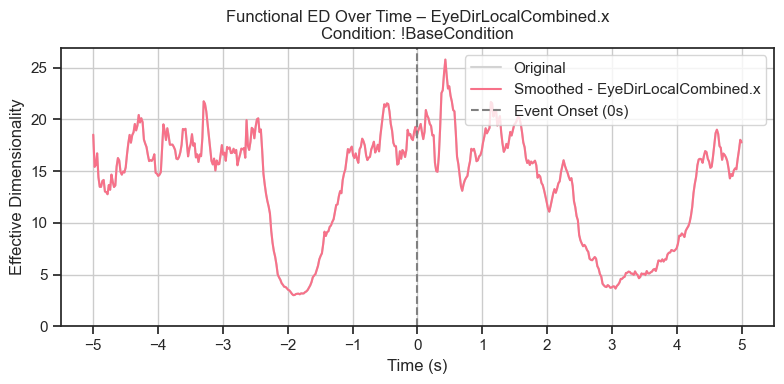

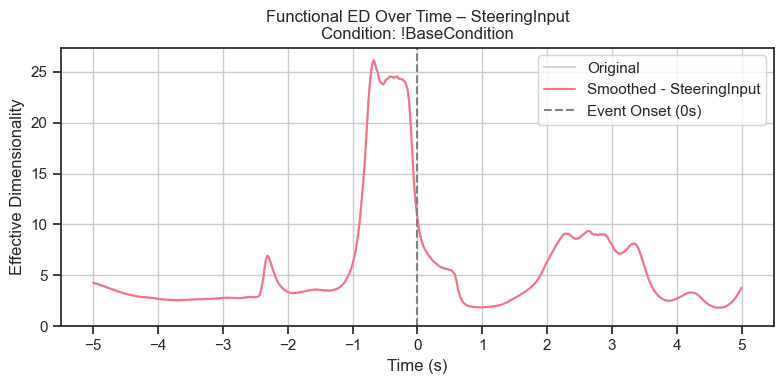

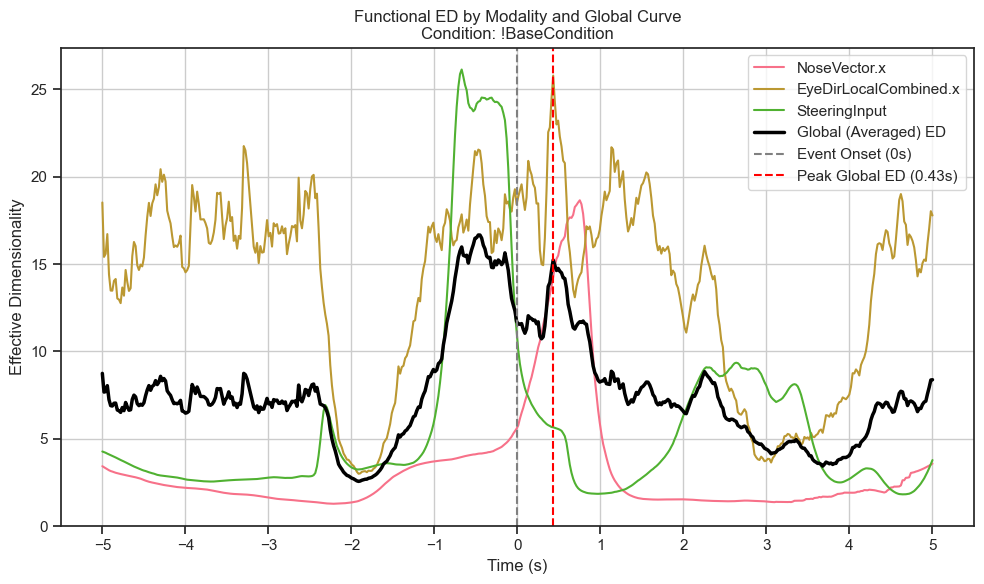

In [122]:
highlight_N = 6  # components to color



n_components = FPCA_eigenfunctions.shape[0]
M = int(FPCA_eigenfunctions.shape[1] / T)
P = len(all_participant_curves)

#   Compute ED curve  
squared = FPCA_eigenfunctions ** 2
weighted = squared * FPCA_eigenvalues[:, np.newaxis]
p_t = weighted / np.sum(weighted, axis=0, keepdims=True)
ED_curve = 1 / np.sum(p_t ** 2, axis=0)
ED_curve_by_modality = ED_curve.reshape(T, M)
print(ED_curve_by_modality.shape)

#   Smooth ED curves per modality  
smoothed_per_modality = np.array([
    gaussian_filter1d(ED_curve_by_modality[:, m], sigma=global_sigma)
    for m in range(M)
]).T

#   Global ED curve  
global_ED = smoothed_per_modality.mean(axis=1)
# Find the index of the maximum ED value after 0 seconds
time_after_zero = np.where(time_sec > 0)[0]  # Get indices where time is greater than 0
peak_time_index = time_after_zero[np.argmax(global_ED[time_after_zero])]  # Find max ED index after 0s

# Get the corresponding time value
peak_time = time_sec[peak_time_index]

#   Plot global ED curve  
plt.figure(figsize=(10, 6))
plt.plot(time_sec, ED_curve_by_modality.mean(axis=1), color='lightblue', label='Original Functional ED')
plt.plot(time_sec, global_ED, color='blue', linewidth=2.5, label='Smoothed Functional ED')
plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak ED ({peak_time:.2f}s)')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.title(f" Functional ED Curve Using FPCA Basis Functions\nCondition: {condition_filter} | Modalities: {modalities} |  FPCA Components: {n_components}, {event_filter_list} " )
plt.xticks(np.arange(-5, 6, 1))
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#   Plot individual component energy over time  
normalized_energy = weighted / np.sum(weighted, axis=0, keepdims=True)
energy_time = normalized_energy.reshape(n_components, T, M).mean(axis=2)
energy_time_smoothed = np.array([gaussian_filter1d(comp, sigma=global_sigma) for comp in energy_time])

colors = cm.viridis(np.linspace(0, 1, highlight_N))
plt.figure(figsize=(10, 6))
for i in range(n_components):
    if i < highlight_N:
        plt.plot(time_sec, energy_time_smoothed[i], label=f'FPC {i+1}', color=colors[i], alpha=0.9)
    else:
        plt.plot(time_sec, energy_time_smoothed[i], color='lightgray', alpha=0.3)
plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak ED ({peak_time:.2f}s)')
plt.xlabel("Time (s)")
plt.ylabel(" Variance Explained")
plt.title(f" Variance Explained by FPCA Components Over Time\nCondition: {condition_filter} | FPCA Components: {n_components}")
plt.xticks(np.arange(-5, 6, 1))
plt.ylim(bottom=0)
plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


#   Print variance explained by top components  
total_var = np.sum(FPCA_eigenvalues)
print(f"\nTop {highlight_N} components (% variance explained):")
for i, val in enumerate(FPCA_eigenvalues[:highlight_N]):
    pct = 100 * val / total_var
    print(f"FPC {i+1}: {pct:.2f}%")


#   Plot ED per modality  
for m in range(M):
    plt.figure(figsize=(8, 4))
    plt.plot(time_sec, ED_curve_by_modality[:, m], color='lightgray', label='Original')
    plt.plot(time_sec, smoothed_per_modality[:, m], label=f"Smoothed - {modalities[m]}", color='C0')
    plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
    plt.xlabel("Time (s)")
    plt.ylabel("Effective Dimensionality")
    plt.title(f"Functional ED Over Time – {modalities[m]}\nCondition: {condition_filter}")
    plt.xticks(np.arange(-5, 6, 1))
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#   Combined modality + global ED plot  
plt.figure(figsize=(10, 6))
for m in range(M):
    plt.plot(time_sec, smoothed_per_modality[:, m], label=modalities[m])
plt.plot(time_sec, global_ED, color='black', linewidth=2.5, label='Global (Averaged) ED')
plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak Global ED ({peak_time:.2f}s)')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.title(f"Functional ED by Modality and Global Curve\nCondition: {condition_filter}")
plt.xticks(np.arange(-5, 6, 1))
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Plot raw variables

# Plot raw variables

# Plot the individual FPCA components ± the mean function

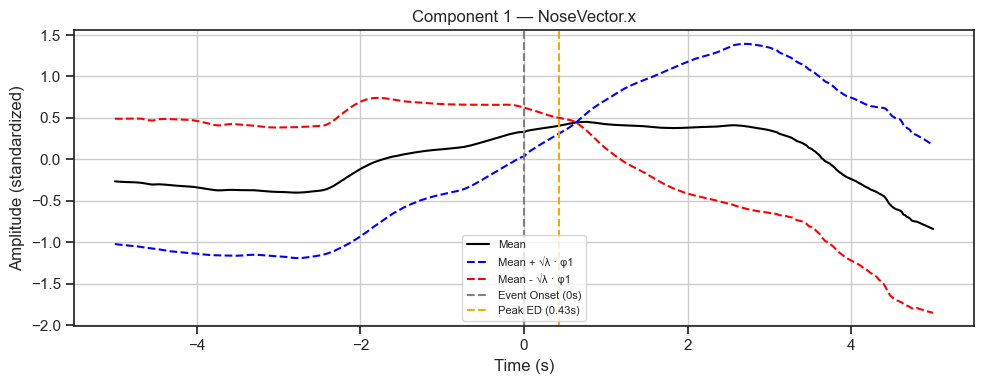

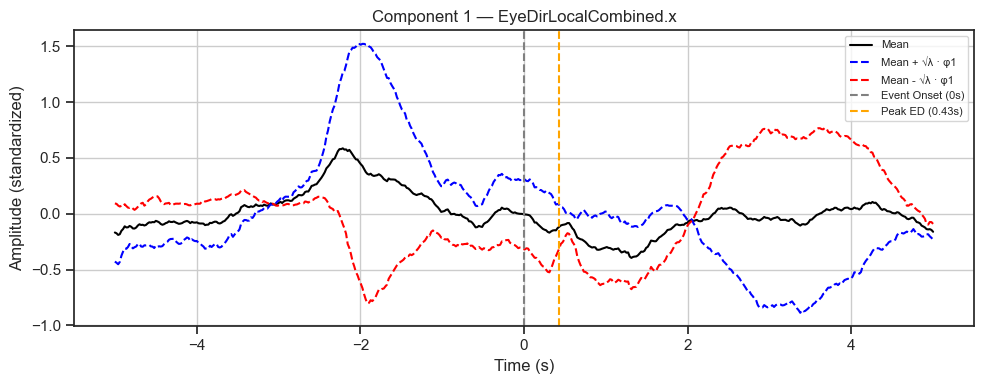

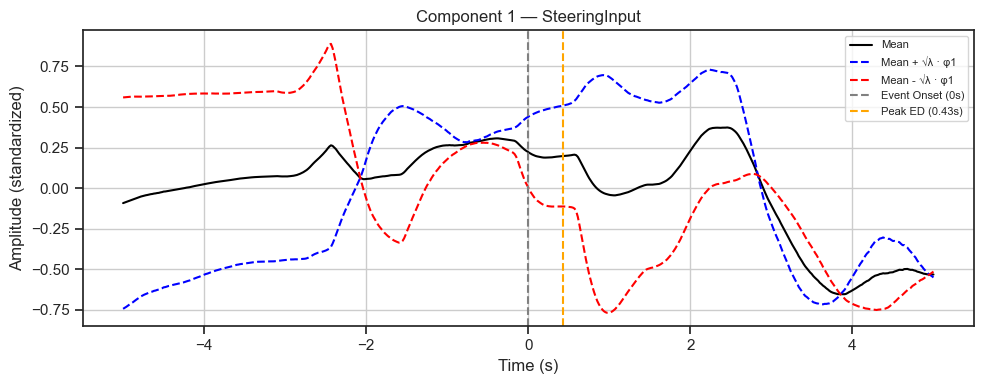

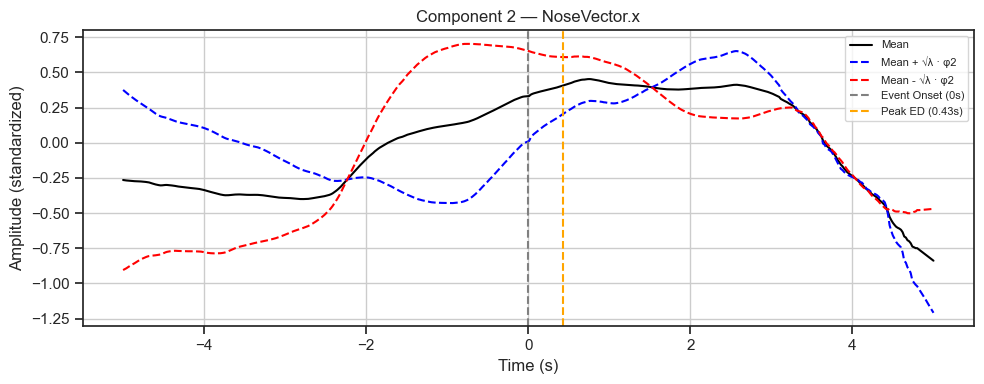

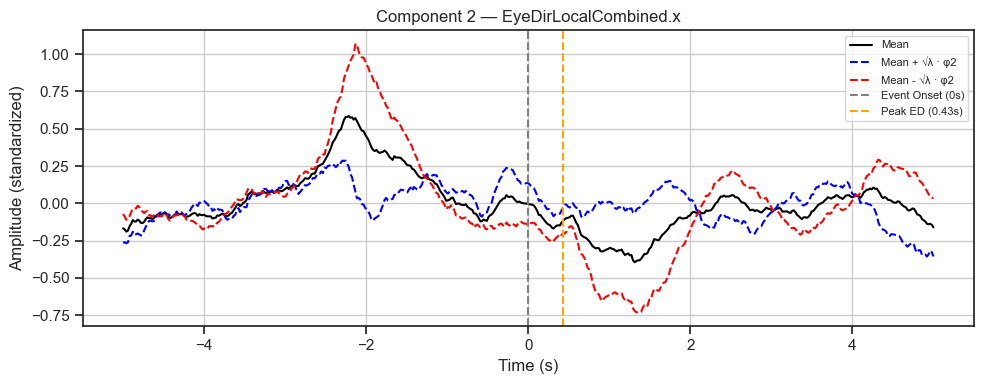

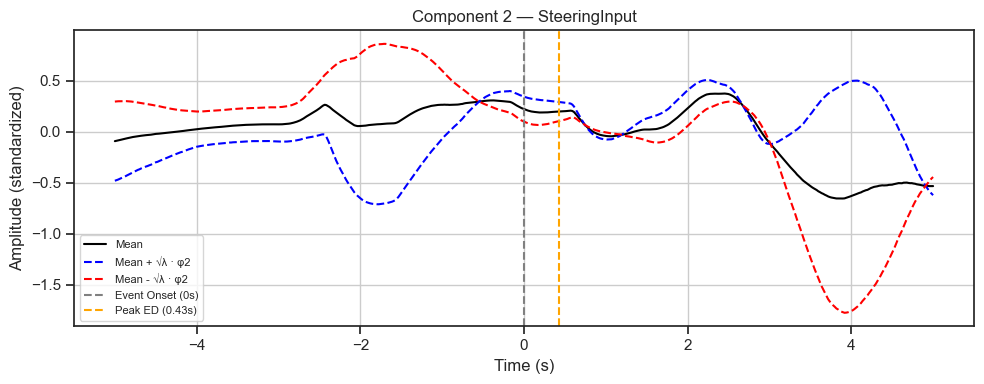

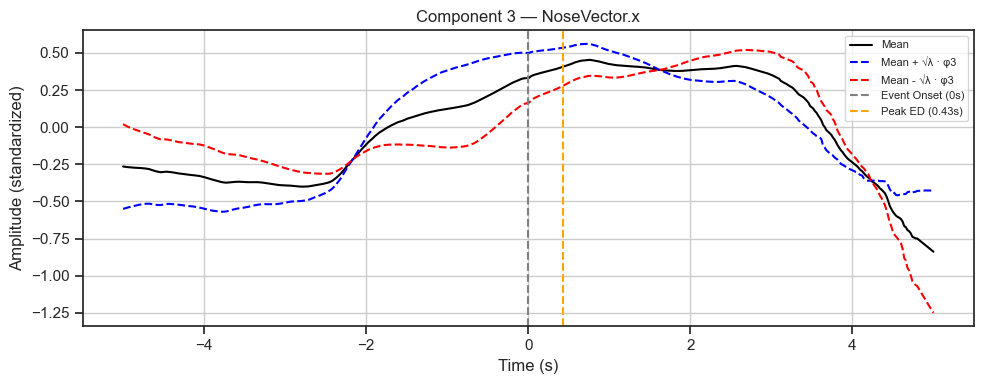

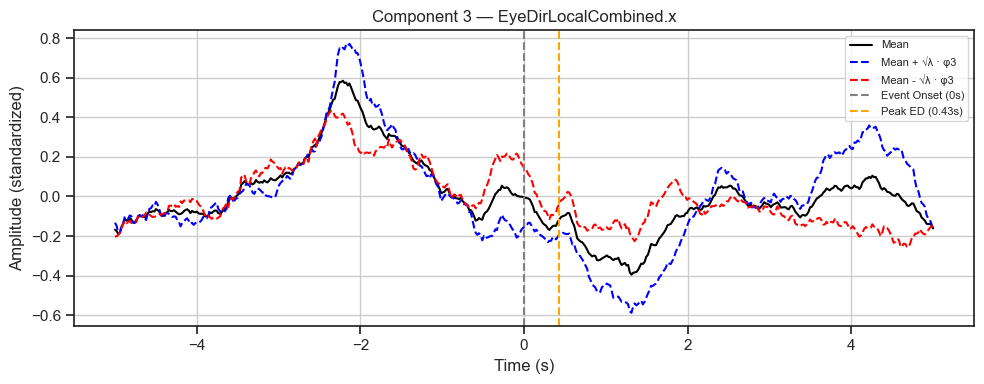

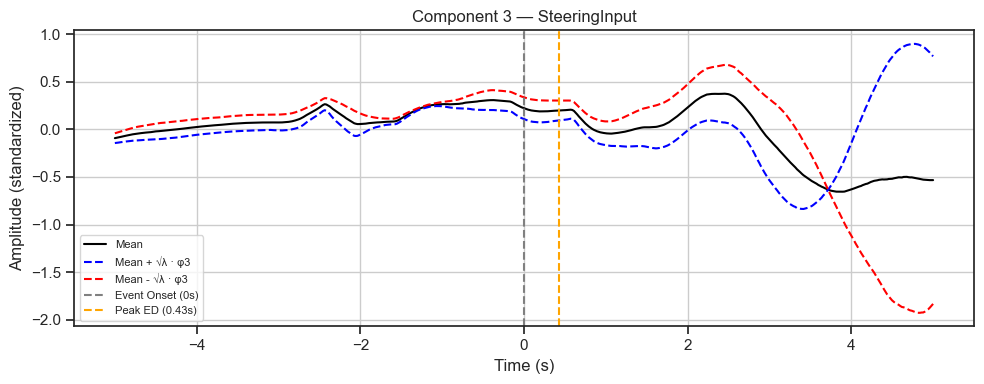

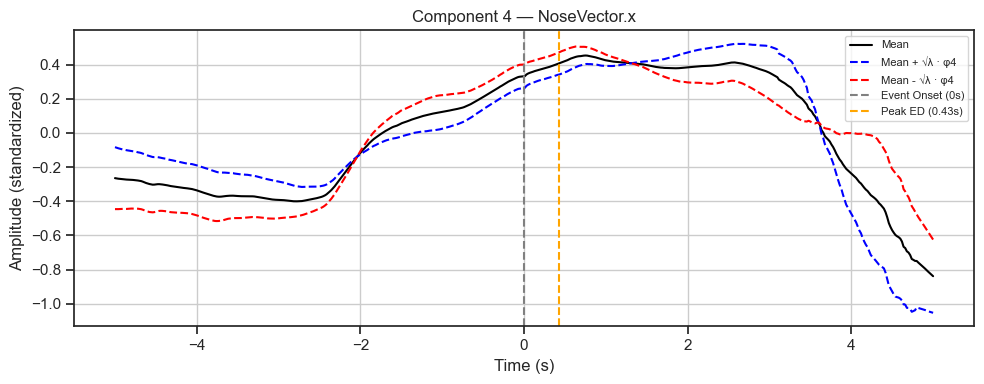

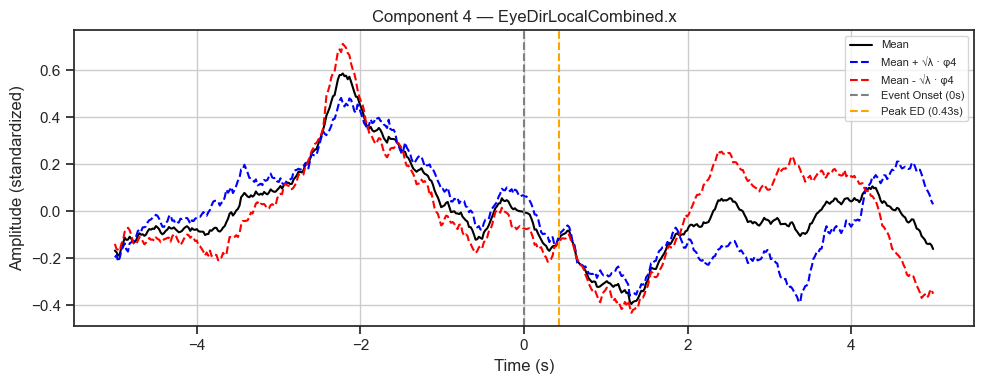

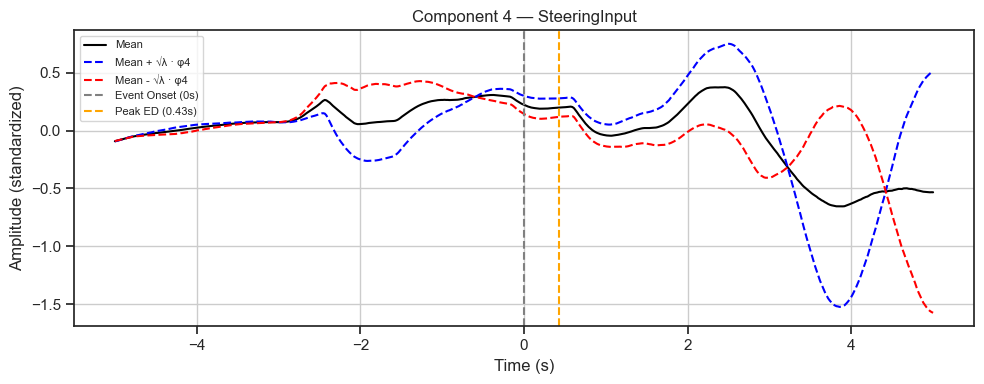

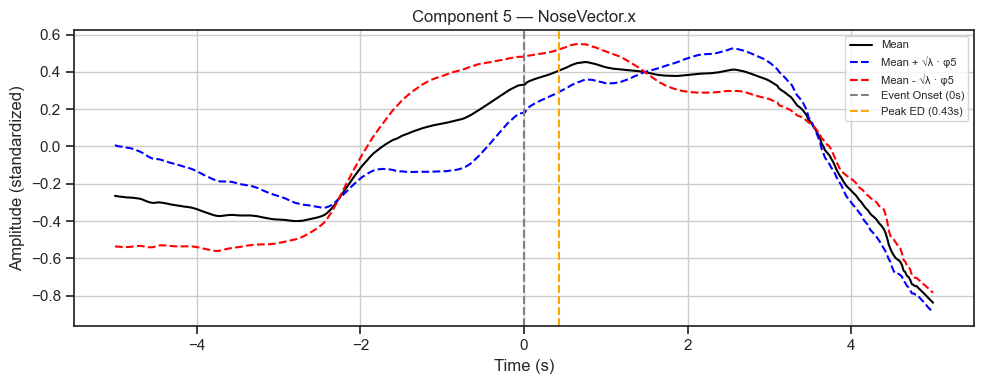

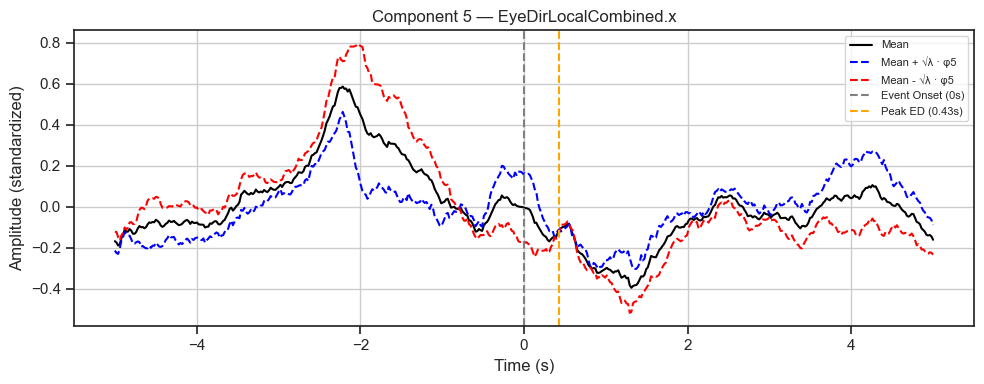

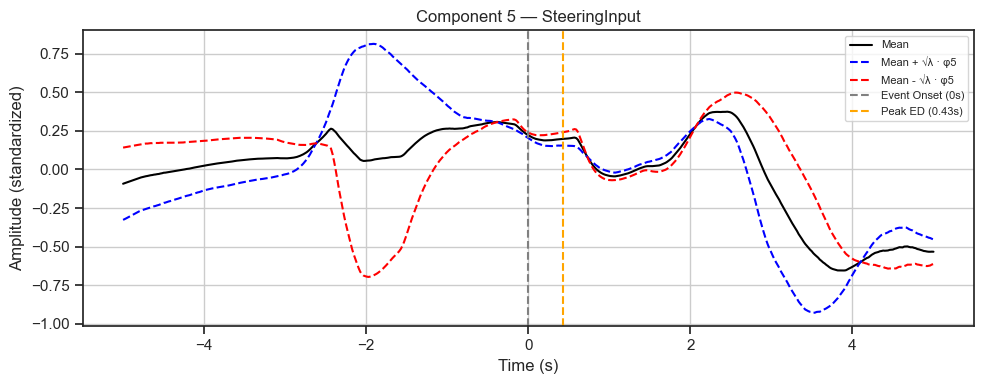

In [123]:
mean_function = fpca.mean_.data_matrix[..., 0]              # shape: (T*M,)

mean_function_reshaped = mean_function.reshape(T, M)        # shape: (T, M)
eigenfunctions_reshaped = FPCA_eigenfunctions.reshape(n_components, T, M)

time = np.linspace(-5, 5, T)
n_show = 5  # Number of components to visualize

for k in range(min(n_show, n_components)):
    for m, modality in enumerate(modalities):
        fig, ax = plt.subplots(figsize=(10, 4))
        mu = mean_function_reshaped[:, m]              # mean curve for modality m
        phi = eigenfunctions_reshaped[k, :, m]         # component k for modality m
        scale = np.sqrt(FPCA_eigenvalues[k])

        # Plot mean ± scaled component
        ax.plot(time, mu, color='black', label='Mean')
        ax.plot(time, mu + scale * phi, linestyle='--', color='blue', label=f'Mean + √λ · φ{k+1}')
        ax.plot(time, mu - scale * phi, linestyle='--', color='red', label=f'Mean - √λ · φ{k+1}')

        # Aesthetics
        ax.set_title(f"Component {k+1} — {modality}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (standardized)")
        ax.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
        ax.axvline(peak_time, color='orange', linestyle='--', label=f'Peak ED ({peak_time:.2f}s)')
        ax.legend(fontsize=8, loc='best')
        ax.grid(True)
        plt.tight_layout()
        plt.show()


# Plot the Eigenfunctions (FPCA Components) as Time-Modality Heatmaps


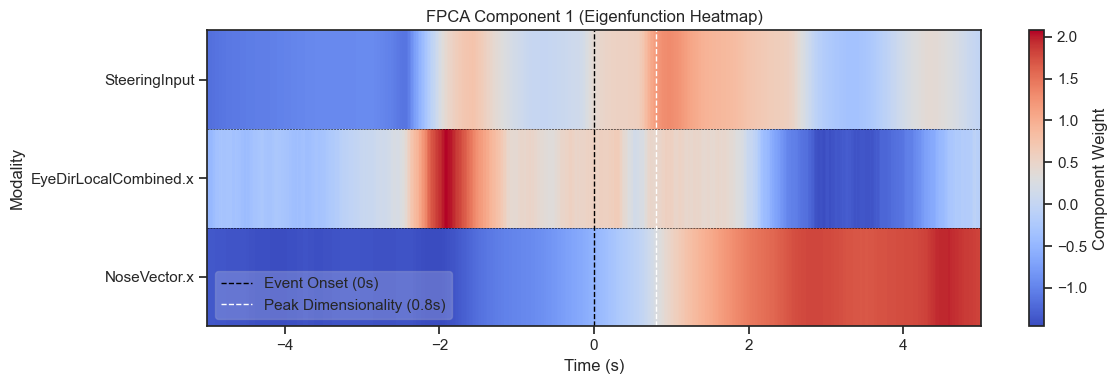

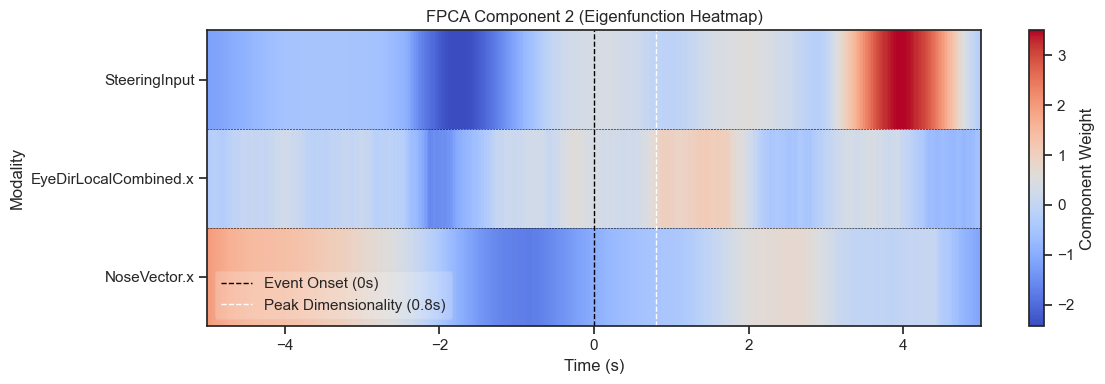

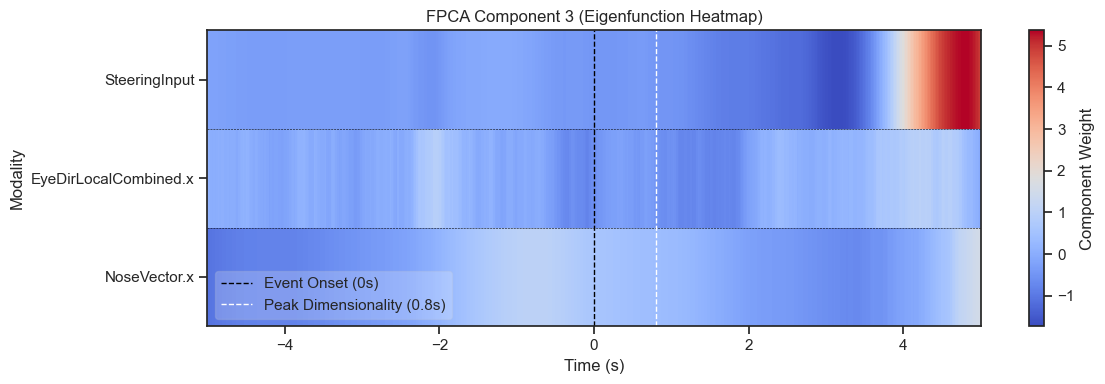

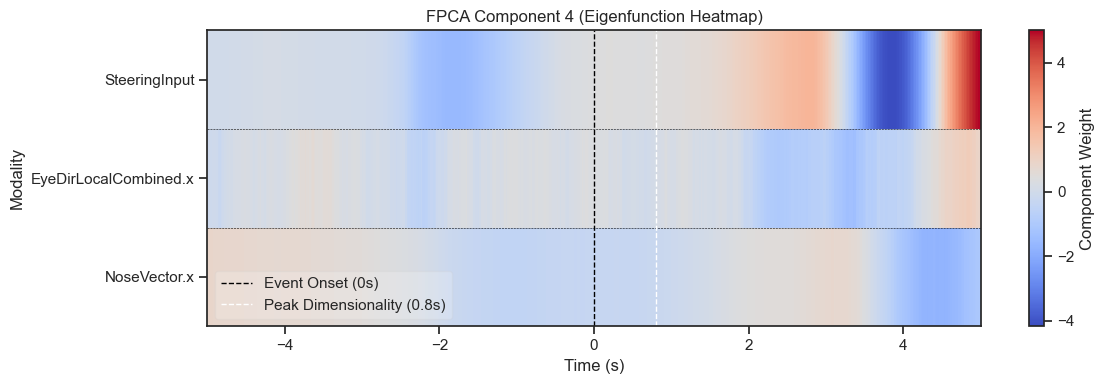

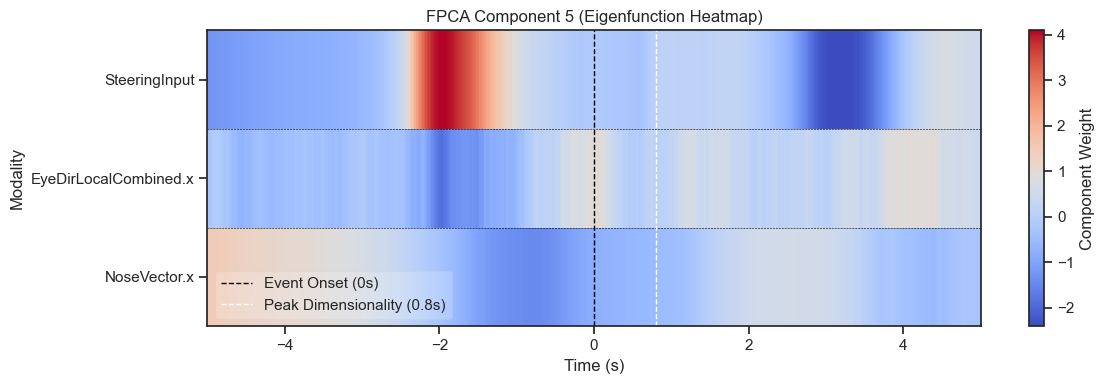

In [124]:
import matplotlib.pyplot as plt
import numpy as np

#   Parameters  
T = 500
M = int(FPCA_eigenfunctions.shape[1] / T)  # ➜ also gives 7

time_sec = np.linspace(-5, 5, T)

#   Reshape Eigenfunctions  
n_components = FPCA_eigenfunctions.shape[0]
reshaped = FPCA_eigenfunctions.reshape(n_components, T, M)  # (n_components, T, M)

#   Customize How Many Components to Plot  
N = 5  #  Adjust number of components to visualize

#   Plot  
for k in range(min(N, n_components)):
    fig, ax = plt.subplots(figsize=(12, 4))
    im = ax.imshow(
        reshaped[k].T,
        aspect='auto',
        cmap='coolwarm',
        extent=[-5, 5, 0, M],
        origin='lower',
        interpolation='none'
    )
    cbar = plt.colorbar(im, ax=ax, label='Component Weight')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Modality")
    ax.set_title(f"FPCA Component {k+1} (Eigenfunction Heatmap)")

    # Modality ticks and separators
    ax.set_yticks(np.arange(M) + 0.5)
    ax.set_yticklabels(modalities)
    for y in range(1, M):
        ax.axhline(y=y, color='black', linewidth=0.4, linestyle='--')

    # Event onset line
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Event Onset (0s)')
    ax.axvline(x=0.8, color='white', linestyle='--', linewidth=1, label='Peak Dimensionality (0.8s)')

    ax.legend(loc='lower left', framealpha =0.2)


    plt.tight_layout()
    plt.show()


# Plot Scores of Participants on the First Few Components

Wider histogram → more variability in the cohort

Skewed histogram → asymmetric behavior (e.g. most people show the pattern positively)

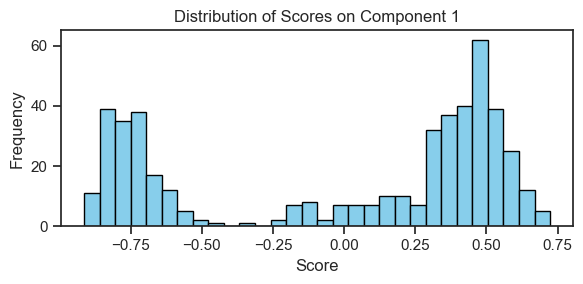

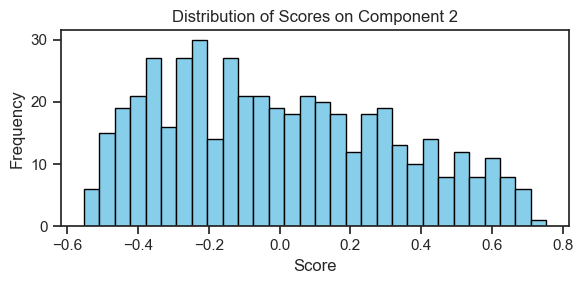

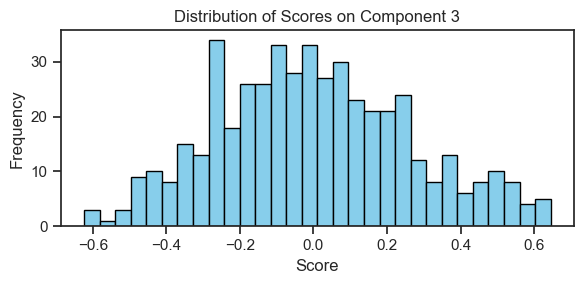

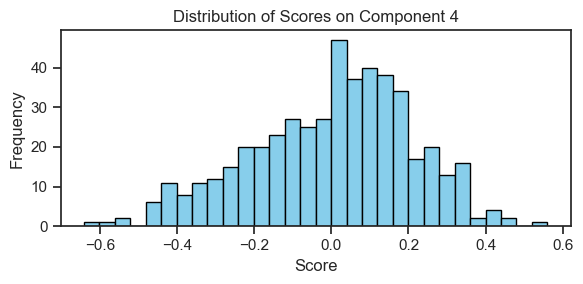

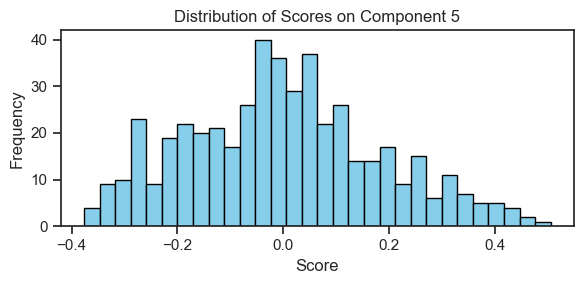

In [125]:
scores = fpca.transform(fd)  # Shape: (N_samples, n_components)

for k in range(N):
    plt.figure(figsize=(6, 3))
    plt.hist(scores[:, k], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of Scores on Component {k+1}")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
